## github рендерит ipynb с ошибками, поэтому используйте nbviewer:
[https://nbviewer.org/github/StalSkyle/stars_classification/blob/main/UNFINISHED_multi_classification.ipynb?flush_cache=true](https://nbviewer.org/github/StalSkyle/stars_classification/blob/main/UNFINISHED_multi_classification.ipynb?flush_cache=true)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ссылка на данные
# https://drive.google.com/file/d/1wTkOoA222guACzvIJxLf4wU77Rykp1__/view?usp=sharing
df = pd.read_parquet("./data/B_vsx_vsx.parquet")
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (16, 12)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9750415 entries, 0 to 9750414
Data columns (total 20 columns):
 #   Column    Dtype  
---  ------    -----  
 0   OID       int32  
 1   n_OID     object 
 2   Name      object 
 3   V         uint8  
 4   Type      object 
 5   l_max     object 
 6   max       float32
 7   u_max     object 
 8   n_max     object 
 9   f_min     object 
 10  l_min     object 
 11  min       float32
 12  u_min     object 
 13  n_min     object 
 14  l_Period  object 
 15  Period    float64
 16  u_Period  object 
 17  Sp        object 
 18  RAJ2000   float64
 19  DEJ2000   float64
dtypes: float32(2), float64(3), int32(1), object(13), uint8(1)
memory usage: 1.3+ GB


In [2]:
def classify_type(vtype: str) -> str:
    """
    Возвращает укрупнённый класс переменной звезды
    в зависимости от содержимого строки vtype.
    """

    if pd.isna(vtype) or not isinstance(vtype, str) or vtype.strip() == "":
        return "UNKNOWN"

    # Приведём к верхнему регистру для надёжного поиска подстрок
    t = vtype.upper()

    # --- 1) Затменные (Eclipsing Binaries) ---
    ecl_markers = ["EA", "EB", "EW", "EC", "ELL", "E/RS", "E|", "E "]
    if any(m in t for m in ecl_markers):
        return "ECLIPSING"

    # --- 2) Цефеиды и родственные (DCEP, CW, RV Tauri, ACEP) - пульсирующие
    cep_markers = ["DCEP", "CW-FU", "CW", "CWA", "CWB", "RVA", "RV", "ACEP", "CEP"]
    if any(m in t for m in cep_markers):
        return "PULSATING"

    # --- 3) RR Лиры (RRAB, RRC, RRD, RR...) - пульсирующие
    rr_markers = ["RRAB", "RRC", "RRD", "RR"]
    if any(m in t for m in rr_markers):
        return "PULSATING"

    # --- 4) Короткопериодические пульсаторы: DSCT, SXPHE, GDOR, roAp - пульсирующие
    short_puls = ["DSCT", "HADS", "SXPHE", "GDOR", "ROAP", "ROAM"]
    if any(m in t for m in short_puls):
        return "PULSATING"

    # --- 5) Долгопериодические и полуправильные (M, SR, L) - пульсирующие
    lpv_markers = ["MIRA", "SR", "SRA", "SRB", "SRC", "SRD", "L ", "LB", "LC", "LPV"]
    if any(m in t for m in lpv_markers):
        return "PULSATING"

    # --- 6) Ротационные переменные (BY, RS, ACV, SPB, ROT, GCAS) ---
    rot_markers = ["BY", "RS", "ACV", "SPB", "ROT", "GCAS"]
    if any(m in t for m in rot_markers):
        return "ROTATING"

    # --- 7) Эруптивные/молодые звёзды (T Tauri, EXOR, UXOR, INS...) ---
    yso_markers = ["TTS", "EXOR", "UXOR", "INS", "IN", "INST", "CST", "DYP", "FSCM", "FUOR", "YSO"]
    if any(m in t for m in yso_markers):
        return "ERUPTIVE"

    # --- 8) Катаклизмические (UG, NL, AM, ZAND, IB, IS, ... ) ---
    cataclysmic_markers = ["UG", "NL", "AM", "ZAND", "IB", "ISB", "BE", "DPV", "EXOR", "FUOR", "PNB"]  # и др.
    if any(m in t for m in cataclysmic_markers):
        return "ERUPTIVE"

    if (t == "E"):
        return "ECLIPSING"

    if (t == "L"):
        return "PULSATING"

    # если ничего не подошло
    return "UNKNOWN"

In [3]:
# целевая переменная:
df["class"] = df["Type"].apply(classify_type)

# в датасете очень мало эруптивных звезд
print(df["class"].value_counts())

class
ROTATING     3102285
PULSATING    3089412
ECLIPSING    2568649
UNKNOWN       892890
ERUPTIVE       97179
Name: count, dtype: int64


In [4]:
df = df[df["class"] != "UNKNOWN"]
df.drop("Type", inplace=True, axis=1)
df.head()

,OID,n_OID,Name,V,l_max,max,u_max,n_max,f_min,l_min,min,u_min,n_min,l_Period,Period,u_Period,Sp,RAJ2000,DEJ2000,class
0,8278100,,Gaia DR3 4685168858707787776,0,,16.59,,G,,,17.740000,,G,,NaN,,K,0.00006,-75.86906,PULSATING
1,2535232,,Gaia DR3 2881873169572728832,0,,16.59,,G,,,16.639999,,G,,2.35407,,G,0.00013,39.89248,ROTATING
2,2535233,,Gaia DR3 4918216945285915648,0,,17.07,,G,,,17.600000,,G,,NaN,,F,0.00019,-59.55921,PULSATING
3,2535234,,Gaia DR3 566749663745310848,0,,15.57,,G,,,15.620000,,G,,NaN,,K,0.00038,81.91627,ROTATING
4,2535235,,Gaia DR3 430093700005970048,0,,14.50,,G,,,14.530000,,G,,NaN,,F,0.00043,63.43314,ROTATING


In [5]:
df.isnull().sum()

OID               0
n_OID             0
Name              0
V                 0
l_max             0
max             443
u_max             0
n_max             0
f_min             0
l_min             0
min           13462
u_min             0
n_min             0
l_Period          0
Period      4593132
u_Period          0
Sp                0
RAJ2000           0
DEJ2000           0
class             0
dtype: int64

In [6]:
df["V"].value_counts()

V
0    8853434
1       2161
2       1138
3        792
Name: count, dtype: int64

In [7]:
# несодержательные признаки
df.drop(["l_max", "u_max", "l_min", "u_min", "l_Period", "u_Period", "OID", "n_OID", "V"], inplace=True, axis=1)

In [8]:
# попробуем извлечь новые признаки из колонки name
df["Name"] = df["Name"].str.split().str[0]

In [9]:
counts = df["Name"].value_counts()
common_types = counts[counts > 1000].index  # часто встречающиеся типы
df["Name"] = df["Name"].apply(lambda x: x if x in common_types else "err")

In [10]:
df["Name"].value_counts() # возможно, затем придётся что-то делать с err

Name
Gaia         6875067
err           856116
ZTF           649501
ASASSN-V      312531
KIC            34633
PS1-3PI        29261
WISE           22634
ASAS           18788
NSVS            8567
MACHO           5744
NSV             4969
OGLE            4078
LINEAR          3991
KID             3947
[CAG2000]       2905
HAT             2877
2MASS           2842
LMC             2578
CoRoT           2349
NGC             2271
EPIC            1953
SEKBO           1885
GSC             1844
HD              1734
BESTII          1414
SDSS            1019
[MAA2010]       1015
[H97b]          1012
Name: count, dtype: int64

In [11]:
# а пока что применим label encoder

le = LabelEncoder()
df["Name"] = le.fit_transform(df["Name"])

In [12]:
df.shape

(8857525, 11)

In [13]:
# теперь перед нами моральный выбор: дропнуть period, или дропнуть строки, в которых period nan
df[df["Period"].notna()]["class"].value_counts()

class
ECLIPSING    2509828
PULSATING    1017772
ROTATING      734431
ERUPTIVE        2362
Name: count, dtype: int64

У эруптивных звёзд *нет периода*, поэтому этот признак является очень важным для их определения.
Попробуем создать новый признак *has_period*$ у звёзд, у которого нет периода, зададим его значение как 0

In [14]:
df["has_period"] = df["Period"].apply(lambda x: 1 if pd.notna(x) else 0)
df["Period"] = df["Period"].fillna(-1) # попробуй еще 0 заполнить

# поместим в df признак has_period после period
col = df.pop("has_period")
df.insert(7, "has_period", col)
df.head()

,Name,max,n_max,f_min,min,n_min,Period,has_period,Sp,RAJ2000,DEJ2000,class
0,7,16.59,G,,17.740000,G,-1.00000,0,K,0.00006,-75.86906,PULSATING
1,7,16.59,G,,16.639999,G,2.35407,1,G,0.00013,39.89248,ROTATING
2,7,17.07,G,,17.600000,G,-1.00000,0,F,0.00019,-59.55921,PULSATING
3,7,15.57,G,,15.620000,G,-1.00000,0,K,0.00038,81.91627,ROTATING
4,7,14.50,G,,14.530000,G,-1.00000,0,F,0.00043,63.43314,ROTATING


In [15]:
df["f_min"].value_counts()

f_min
     7165690
Y    1691835
Name: count, dtype: int64

In [16]:
df["f_min"] = df["f_min"].apply(lambda x: 1 if x == "Y" else 0)
df["f_min"].value_counts()

f_min
0    7165690
1    1691835
Name: count, dtype: int64

In [17]:
df.head()

,Name,max,n_max,f_min,min,n_min,Period,has_period,Sp,RAJ2000,DEJ2000,class
0,7,16.59,G,0,17.740000,G,-1.00000,0,K,0.00006,-75.86906,PULSATING
1,7,16.59,G,0,16.639999,G,2.35407,1,G,0.00013,39.89248,ROTATING
2,7,17.07,G,0,17.600000,G,-1.00000,0,F,0.00019,-59.55921,PULSATING
3,7,15.57,G,0,15.620000,G,-1.00000,0,K,0.00038,81.91627,ROTATING
4,7,14.50,G,0,14.530000,G,-1.00000,0,F,0.00043,63.43314,ROTATING


In [18]:
# всего 443 звезды не имеют признака max, поэтому дропнем их
df = df[df["max"].notna()]

# аналогично с min
df = df[df["min"].notna()]

In [19]:
counts = df["Sp"].value_counts()
common_types = counts[counts > 1000].index.to_list()
print(len(df[df["Sp"].isin(common_types)]), "нередкие с nan")
common_types.remove("")
print(len(df[df["Sp"].isin(common_types)]), "нередкие без nan")

8805306 нередкие с nan
4514800 нередкие без nan


In [20]:
# пусть редкий признак будет закодирован как "rare", а отсутствие признака - как "no"
df["Sp"] = df["Sp"].replace("", "none")
df["Sp"] = df["Sp"].apply(lambda x: "rare" if x not in common_types + ["none"] else x)

In [21]:
df["Sp"].value_counts()

Sp
none    4290506
K       1606290
M        871682
F        736688
G        711373
A        421088
B        120353
rare      38505
O         28113
C         15756
F0         1315
em         1123
G7         1019
Name: count, dtype: int64

In [22]:
df["n_max"].value_counts()

n_max
G     6876366
Ic     679859
r      622783
V      258564
g      216882
       ...   
BP          1
Bj          1
pv          1
EW          1
L           1
Name: count, Length: 62, dtype: int64

In [23]:
# разберемся с n_max
# сделаем то же самое, что и с Sp
print(len(df[df["n_max"] == ""])) # всего 688 значений, можем смело дропать
df = df[df["n_max"] != ""]
counts = df["n_max"].value_counts()
common_types = counts[counts > 1000].index.to_list()
df["n_max"] = df["n_max"].apply(lambda x: "rare" if x not in common_types else x)
df["n_max"].value_counts()

688


n_max
G       6876366
Ic       679859
r        622783
V        258564
g        216882
CV        99785
Kp        37079
W1        13011
pg        11533
R1         5344
CR         5051
B          3905
rare       3269
I          2974
R          2405
J          2207
Hp         2106
Name: count, dtype: int64

In [24]:
df["n_max"].value_counts()

n_max
G       6876366
Ic       679859
r        622783
V        258564
g        216882
CV        99785
Kp        37079
W1        13011
pg        11533
R1         5344
CR         5051
B          3905
rare       3269
I          2974
R          2405
J          2207
Hp         2106
Name: count, dtype: int64

In [25]:
# ну и n_min
print(len(df[df["n_min"] == ""])) # отлично
df["n_min"].value_counts()

0


n_min
G        6875225
Ic        680229
r         625127
V         255036
g         216630
          ...   
Bj             1
[3.6]          1
B*             1
pv             1
L              1
Name: count, Length: 63, dtype: int64

In [26]:
counts = df["n_min"].value_counts()
common_types = counts[counts > 1000].index.to_list()
df["n_min"] = df["n_min"].apply(lambda x: "rare" if x not in common_types else x)
df["n_min"].value_counts()

n_min
G       6875225
Ic       680229
r        625127
V        255036
g        216630
CV       100118
Kp        37257
W1        13053
pg        11539
R1         5697
CR         5407
B          4519
rare       3706
I          2966
R          2469
Hp         2162
w          1983
Name: count, dtype: int64

In [27]:
df.head()

,Name,max,n_max,f_min,min,n_min,Period,has_period,Sp,RAJ2000,DEJ2000,class
0,7,16.59,G,0,17.740000,G,-1.00000,0,K,0.00006,-75.86906,PULSATING
1,7,16.59,G,0,16.639999,G,2.35407,1,G,0.00013,39.89248,ROTATING
2,7,17.07,G,0,17.600000,G,-1.00000,0,F,0.00019,-59.55921,PULSATING
3,7,15.57,G,0,15.620000,G,-1.00000,0,K,0.00038,81.91627,ROTATING
4,7,14.50,G,0,14.530000,G,-1.00000,0,F,0.00043,63.43314,ROTATING


In [28]:
le = LabelEncoder()
df["n_max"] = le.fit_transform(df["n_max"])

le = LabelEncoder()
df["n_min"] = le.fit_transform(df["n_min"])

le = LabelEncoder()
df["Sp"] = le.fit_transform(df["Sp"])

# TODO
-оформить что-то в функцию - потом  

-почему n_max и n_min так похожи: это количество измерений, можно потом попробовать дропнуть  

-всё-таки посмотреть, что значат названия фич  

-матрица корреляций  

-посмотреть распределения  

-мне кажется, что еще и name будет сильно похоже  

-решить, что делать с координатами (пока только нормализуем)  

## наконец-то переходим к обучению:

-попробовать регрессию  
-мб нейронку

In [29]:
# создадим новый признак - амплитуда (min - max)
df["range"] = df["min"] - df["max"]

In [30]:
# преобразуем class в численные значения
target_classifier = LabelEncoder()
df["class"] = target_classifier.fit_transform(df["class"])
df.head()

,Name,max,n_max,f_min,min,n_min,Period,has_period,Sp,RAJ2000,DEJ2000,class,range
0,7,16.59,3,0,17.740000,3,-1.00000,0,7,0.00006,-75.86906,2,1.150000
1,7,16.59,3,0,16.639999,3,2.35407,1,5,0.00013,39.89248,3,0.049999
2,7,17.07,3,0,17.600000,3,-1.00000,0,3,0.00019,-59.55921,2,0.530001
3,7,15.57,3,0,15.620000,3,-1.00000,0,7,0.00038,81.91627,3,0.050000
4,7,14.50,3,0,14.530000,3,-1.00000,0,3,0.00043,63.43314,3,0.030000


<Axes: >

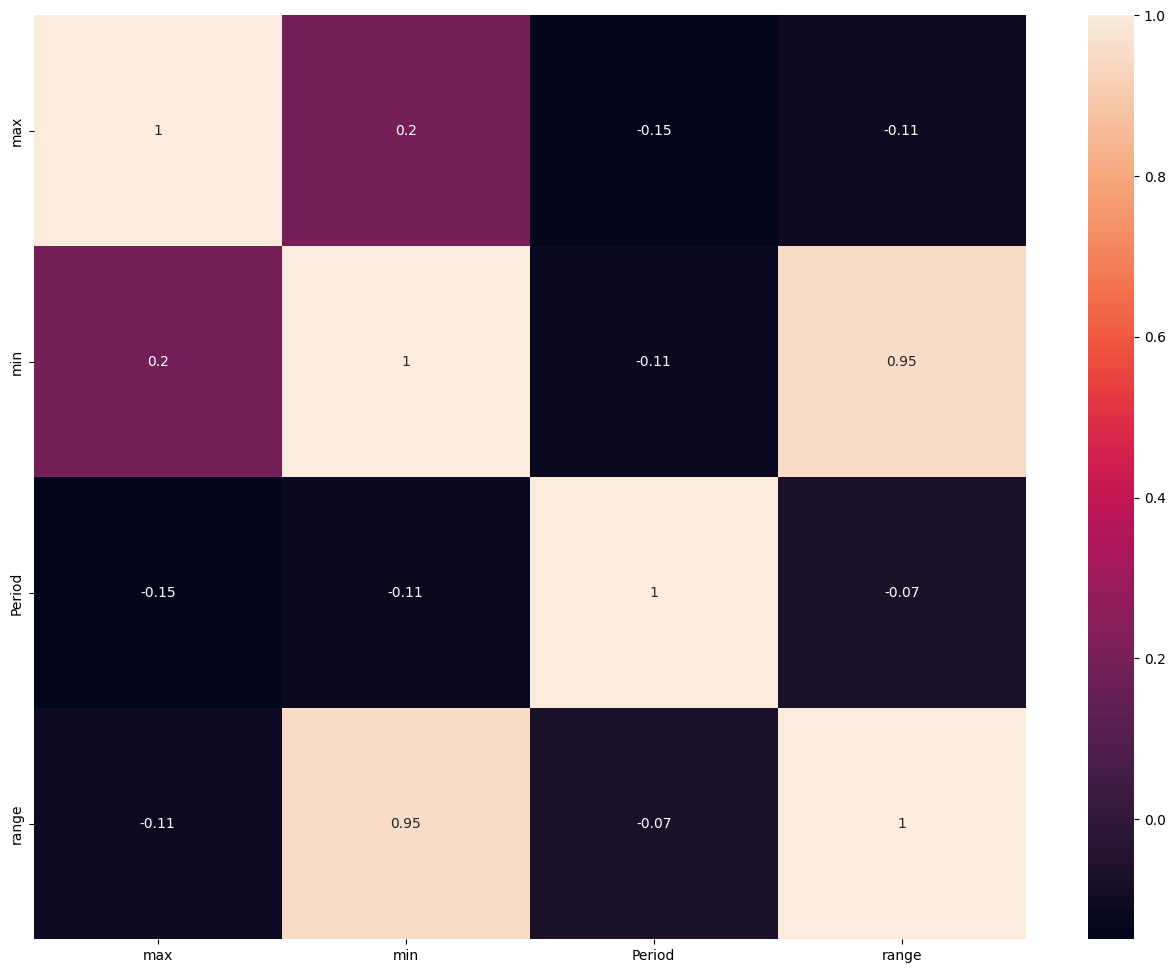

In [31]:
numerical = ["max", "min", "Period", "range"]
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix, annot=True) # попробуем затем обучиться без range

In [33]:
# скейлим
from sklearn.preprocessing import StandardScaler
scaled_cols = ["max", "min", "Period", "RAJ2000", "DEJ2000", "range"]

scaler = StandardScaler()
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

## попробуем обучить

In [38]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df[[x for x in df.columns if x != "class"]]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

lr = LogisticRegression(class_weight='balanced', max_iter=1000) # 2500 потом

lr.fit(X_train, y_train)

/home/stalskyle/Рабочий стол/for_ml/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [39]:
y_pred = lr.predict(X_test)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["ECLIPSING", "ERUPTIVE", "PULSATING", "ROTATING"]))

              precision    recall  f1-score   support

   ECLIPSING       0.73      0.92      0.81    512267
    ERUPTIVE       0.05      0.69      0.09     19070
   PULSATING       0.60      0.41      0.49    617273
    ROTATING       0.62      0.44      0.51    620015

    accuracy                           0.57   1768625
   macro avg       0.50      0.61      0.48   1768625
weighted avg       0.64      0.57      0.59   1768625



In [81]:
# ожидаемо, модель плохо научилась предсказывать редкий класс
# попробуем применить CatBoost, который автоматически учитывает дисбаланс классов
# сначала попробуем обучить на меньшем датасете (300 000 строк), чтобы подобрать параметры
def stratified_sample(df, class_column, sample_size):
    return df.groupby(class_column, group_keys=False)\
             .apply(lambda x: x.sample(frac=sample_size/len(df)))

subset = stratified_sample(df, 'class', 300000)
subset["class"].value_counts()

/tmp/ipykernel_8618/3058191652.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=sample_size/len(df)))


class
3    105169
2    104704
0     86893
1      3235
Name: count, dtype: int64

In [86]:
from catboost import CatBoostClassifier

sub_X = subset[[x for x in df.columns if x != "class"]]
sub_y = subset["class"]

print(sub_X.shape)
print(sub_y.shape)

sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(
    sub_X, sub_y,
    stratify=sub_y,
    test_size=0.2,
    random_state=42
)

(300001, 12)
(300001,)


In [87]:
%%time
cb = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='TotalF1')
cb.fit(
    sub_X_train, sub_y_train,
    logging_level='Silent',
    # eval_set=(sub_X_test, sub_y_test),
    # use_best_model=True
)

CPU times: user 6min 27s, sys: 1min 18s, total: 7min 46s
Wall time: 31.3 s


In [88]:
sub_y_pred = cb.predict(sub_X_test)

In [89]:
from sklearn.metrics import classification_report
print(classification_report(sub_y_pred, sub_y_test, target_names=["ECLIPSING", "ERUPTIVE", "PULSATING", "ROTATING"]))

              precision    recall  f1-score   support

   ECLIPSING       0.96      0.92      0.94     18139
    ERUPTIVE       0.80      0.23      0.36      2227
   PULSATING       0.89      0.94      0.91     19842
    ROTATING       0.89      0.95      0.92     19793

    accuracy                           0.91     60001
   macro avg       0.88      0.76      0.78     60001
weighted avg       0.91      0.91      0.90     60001



In [ ]:
# такое уже нравится больше, хотя recall для eruptive всё ещё низкий
# попробуем обучить на всех данных

In [93]:
%%time
cb_full_data = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='TotalF1')
cb_full_data.fit(
    X_train, y_train,
    logging_level='Silent',
)

CPU times: user 3h 35min 49s, sys: 14min, total: 3h 49min 49s
Wall time: 17min 31s


In [94]:
y_pred = cb.predict(X_test)

In [96]:
print(classification_report(y_pred, y_test, target_names=["ECLIPSING", "ERUPTIVE", "PULSATING", "ROTATING"]))

              precision    recall  f1-score   support

   ECLIPSING       0.96      0.92      0.94    534330
    ERUPTIVE       0.80      0.24      0.37     63882
   PULSATING       0.89      0.94      0.92    584058
    ROTATING       0.89      0.95      0.92    586355

    accuracy                           0.91   1768625
   macro avg       0.89      0.76      0.78   1768625
weighted avg       0.91      0.91      0.90   1768625



был применен андерсемплинг (использован алгоритм NearMiss из библиотеки imblearn), но результат улучшить не получилось